In [1]:
# Standard classification main code
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dir = '/content/drive/MyDrive/Master/DesignExperimentML/Assignment/'

Mounted at /content/drive


### **Libraries and written functions**

In [6]:
import os
import sys
import csv
import random
import math
import numpy as np
import pandas
from __future__ import print_function

! pip install cobra
! pip install silence_tensorflow

# Tensorflow might generate WARNINGS because of GPU unused, silence it
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# COBRA utilities

import cobra
import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution 
from cobra.flux_analysis import pfba

def read_out_flux_list(filename):
    """
    Read outgoing fluxes found in filename
    File format is: metabolite name, and other unsused parameters
    Returns dictonary with name as key and zero value, OUT[metabolite name] = 0
    """
    filename += '.csv'
    OUT = {}
    with open(filename) as h:
        for line in h:
            K = line.rstrip().split(',')
    for i in range(len(K)):
        OUT[K[i]] = 0
    return OUT

def write_training_set_cobra(DATA, filename, newfile = True):
    """
    Write DATA (a dictionay) in filename 
    First line of the file contains the header (i.e., flux-names)
    Subsequent lines are the values
    """
    filename += '.csv'
    with open(filename, 'w') as h:
        data = DATA[0] # print header
        if newfile:
            h.write(','.join(str(k) for k in data.keys()))
            h.write('\n') 
        for n in DATA.keys(): # print values
            data = DATA[n]
            h.write(','.join(str(k) for k in data.values()))
            h.write('\n')

def read_training_set_cobra(filename):
    """
    Read DATA stored in filename, see above for file format
    Return a dictionary DATA[name] = value
    """
    filename += '.csv'
    DATA = {}; n = 0
    with open(filename) as h:
        lines = h.readlines()
        K = lines[0].rstrip().split(',')
        for n in range(1,len(lines)):
            V = lines[n].rstrip().split(','); data = {}
            for i in range(len(V)): data[K[i]] = V[i] 
            DATA[n-1] = data
    return DATA

def run_cobra(model,IN,OUT,verbose=False):
    """
    Run FBA optimization to compute fluxes on the provided model
    Set the medium using values in dictionary IN
    Returns a dictionary (FLUX) with the fluxes for 
    The metabolites found in dictionary OUT
    """

    # set the medium
    medium = model.medium # This is the model medium   
    for r in medium.keys():
        medium[r] = 10.0 # Allow to get some growth   
    for k in IN.keys(): # Additional cmpds added to medium
        medium[k] = float(IN[k])       
    model.medium = medium
    #print('medium=',medium)
    
    # run FBA
    solution = model.optimize()
    if verbose:
        print('objectif =',solution.objective_value)
    #model.summary()  
    
    # get the outgoing fluxes for cmpds listed in OUT
    FLUX = OUT.copy()
    for x in model.reactions:
        if solution.fluxes[x.id] != 0:
            for y in x.products:
                if y.id in FLUX.keys():
                    FLUX[y.id] += solution.fluxes[x.id]
    for y in FLUX.keys():
        if math.fabs(float(FLUX[y])) < 0.001: 
          # 10^-3 must be able to measure it
            FLUX[y] = 0
            
    # Reset additional cmpds added to the medium
    medium = model.medium
    for k in IN.keys():
        medium[k] = 0.0
    model.medium = medium
    
    return FLUX, solution


def create_output_training_set_cobra(OUT, INFLUX, cobrastrain=None, 
                                     cobrafile=None):
    # Run Cobra for a series of input fluxes in INFLUX 
    # names of outgoing fluxes are in OUT list
    # Get and return the fluxes for the metabolites in OUT
    if cobrastrain == None:
        if cobrafile == None:
            sys.exit('Error: Must provide a file for COBRA !')
        cobrastrain = cobra.io.read_sbml_model(cobrafile) 
    OUTFLUX = {}
    for n in range(len(INFLUX.keys())):
        OUTFLUX[n], solution = run_cobra(cobrastrain,INFLUX[n],OUT)
    return cobrastrain, OUTFLUX

# Learning and x-validation utilities using Keras and sklearn

import keras
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras.backend as K
from keras import initializers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input, Dense, LSTM, Dropout, Flatten
from keras.layers import Lambda, Reshape
from keras.layers import multiply, concatenate, add, subtract, dot
from keras.constraints import unit_norm, NonNeg
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import precision_recall_curve

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fast')

def scale(data):
    # standardize data
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)

def read_training_data(filename):
    filename += '.csv'
    dataframe = pandas.read_csv(filename, header=0)
    dataset = dataframe.values
    DATA = np.asarray(dataset[:,:])
    return DATA

def read_XY(model_in, model_out):
    # Format date for training
    X = scale(read_training_data(model_in))
    Y = read_training_data(model_out)
    return X,Y

def write_training_results(R,filename):
    filename += '.csv'
    with open(filename, 'w') as h:
        # header
        h.write(','.join('res'+str(k) for k in range(R.shape[0]) ))
        h.write('\n')
        # data
        for i in range(0,R.shape[0]):
            h.write(','.join(str(R[i][k]) for k in range(R.shape[1])))
            h.write('\n')

class MODEL:
    def __init__(self, model, 
                 input_dim, output_dim, n_hidden, 
                 output_activation, dropout):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_hidden = n_hidden
        self.output_activation = output_activation
        self.dropout = dropout

def my_accuracy(y_true, y_pred):
    """Binary accuracy"""
    return keras.metrics.binary_accuracy(y_true[:,0:1], y_pred[:,0:1])

def create_model(input_dim, output_dim, 
                 activation='linear', 
                 n_hidden=0, dropout=0.1, 
                 loss='mse', metrics=['mae'],  
                 verbose=False):
    # Build and return a simple dense model. 
    inputs  = Input(shape=(input_dim,)) 
    hidden  = inputs
    hidden_dim=input_dim
    # Hiden layers
    for i in range(n_hidden):
        hidden    = Dense(hidden_dim, kernel_initializer='normal', 
                          activation='relu' ) (hidden) 
        hidden    = Dropout(dropout)(hidden) 
    # Output layer
    outputs = Dense(output_dim, kernel_initializer='normal', 
                    activation=activation) (hidden)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    if verbose: print(model.summary())
    return MODEL(model, input_dim, output_dim, n_hidden, activation, dropout)

def ROC(X, Y, Network, xfold=10, epochs=1000, batch_size=10, color = 'blue'):
    """
    Plot a ROC curve using X, Y and a model Network
    """
    test_size = 1.0 - 1.0/xfold # to get a ratio
    X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=test_size)
    Network.model.fit(X_train, Y_train, epochs=epochs, 
                      batch_size=batch_size, verbose=False)
    Y_pred = Network.model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    AUC = auc(fpr, tpr)
    plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(9,7))
    plt.plot([0, 1], [0, 1], 'k--',  lw=2.8)
    plt.plot(fpr, tpr, lw=2.8, color=color,label='Area = {:.3f}'.format(AUC))
    plt.fill_between(fpr, tpr,color=color, alpha=0.28)
    plt.xlabel('False positive rate',family="serif",fontsize = 26)
    plt.ylabel('True positive rate',family="serif",fontsize = 26)
    plt.title('ROC curve {}-Fold'.format(xfold),family="serif",fontsize = 35)
    plt.legend(prop={'size':20, 'family':'serif'},loc='lower right')
    plt.show()

def PR(X, Y, Network, xfold=10, epochs=1000, batch_size=10, color = 'blue'):
    """
    Plot a ROC curve using X, Y and a model Network
    """
    test_size = 1.0 - 1.0/xfold # to get a ratio
    X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=test_size)
    Network.model.fit(X_train, Y_train, epochs=epochs, 
                      batch_size=batch_size, verbose=False)
    Y_pred = Network.model.predict(X_test).ravel()
    fpr, tpr, thresholds = precision_recall_curve(Y_test, Y_pred)
    AUC = auc(fpr, tpr)
    plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(9,7))
    plt.plot([0, 1], [0, 1], 'k--',  lw=2.8)
    plt.plot(fpr, tpr, lw=2.8, color=color,label='Area = {:.3f}'.format(AUC))
    plt.fill_between(fpr, tpr,color=color, alpha=0.28)
    plt.xlabel('Recall',family="serif",fontsize = 26)
    plt.ylabel('Precision',family="serif",fontsize = 26)
    plt.title('PR curve {}-Fold'.format(xfold),family="serif",fontsize = 35)
    plt.legend(prop={'size':20, 'family':'serif'},loc='lower right')
    plt.show()


# Training Neural Network models for classification
def train_model_classification(X,Y, 
                               activation= 'sigmoid', 
                               loss = 'binary_crossentropy',
                               n_hidden=1, dropout=0.1,
                               epochs=100, batch_size=10,
                               niter=1, xfold=5, seed=10, 
                               verbose=False):
    """ 
        X is the input data, Y is a binary array (used for the classification)
        This function divides the data into xfold segments and perform a loop over them.
        The small segment is selected for the test data and the rest for the training.
        In each loop the neural network model is applied and the best model is selected.
        This function returns:
          1. The best model, with the best mean accuracy.
          2. The predictions obtained during the test step by using the best model.
          3. The mean accuracy and the standard deviation of the best model.
    """
    
    #Apply normalization operation for numerical stability
    standardizer = StandardScaler()
    X = standardizer.fit_transform(X)
    
    # Get model parameters 
    input_dim = X.shape[1]
    output_dim = Y.shape[1]
    hidden_dim = input_dim
    if verbose:
        print("Training size = %d input_dim = %d output_dim = %d hidden_dim = %d nbr_hidden = %d epochs = %d, batch_size= %d" 
              % (len(Y),input_dim, output_dim,
                 hidden_dim, n_hidden,
                 epochs, batch_size))

    #Initial values    
    Accuracy_best = 0
    value = None
    Accuracy_test = np.array([])
    model_train= {}

  
    # Repeat for all iteration
    for n in range(niter):

      #Initial value of the iterator
      i=0
      #kfold with KFold()
      kf = KFold(n_splits = xfold, shuffle = True, random_state = seed+n)

      #Repeat xfold times
      for train_index, test_index in kf.split(X, Y):
        
          # 1. Split train/test
          #print("Index train:", train_index, "Index test:", test_index)
          X_train, X_test = X[train_index], X[test_index]
          Y_train, Y_test = Y[train_index], Y[test_index]

          # 2. Create and train model
          model_train["model{}".format(i+1+n*xfold)] = create_model(input_dim= input_dim, output_dim=output_dim, activation=activation, n_hidden=n_hidden, dropout=dropout, loss=loss, metrics=[my_accuracy], verbose=False)
          model_train["model{}".format(i+1+n*xfold)].model.fit(x=X_train, y= Y_train, batch_size=batch_size, epochs=epochs, verbose=False)
          
          # 3. Compute accuracy on TEST SET

          # Validation set evaluation
          val_Loss, val_Accuracy = model_train["model{}".format(i+1+n*xfold)].model.evaluate(X_test, Y_test,  verbose=False)
          Accuracy_test = np.append(val_Accuracy , Accuracy_test)

          # Validation set predict
          # Y_test_predict = np.where(model_train["model{}".format(i+1+n*xfold)].model.predict(X_test) > 0.5, 1, 0 )
          # pred_Accuracy = accuracy_score(Y_test, Y_test_predict)

          if val_Accuracy > Accuracy_best:
            Accuracy_best = val_Accuracy
            value = i+1+n*xfold

          #Iteration
          i=i+1
      
    #The best model
    Y_test_predict = model_train["model{}".format(value)].model.predict(X)

    # Return 1. The best model, 2. the predictions made by best model 3. the average accuracy and 4. the stdev
    return model_train["model{}".format(value)], Y_test_predict, Accuracy_test.mean() , Accuracy_test.std()


def remove_column(X,j): 
  """
  Remove column j from matrix X and return reduced matrix
  """
  XX = np.zeros((X.shape[0], X.shape[1]-1), dtype=X.dtype)
  XX[:, :j] = X[:, :j]
  XX[:, j:] = X[:, j+1:]
  return(XX)

def remove_column_best(X,Y, n_hidden=2, dropout=0.1,
                      epochs=100, batch_size=10,niter=1, xfold=5,
                      seed=10, verbose=False):
  """
  Search the column in X which once removed lead to the highest (above 0.8)
  X-validation accuracy
  """
  
  # Initial parameters
  N = X.shape[1]
  Acc_avr_best = 0
  Acc_dev_best = 0
  column_best = -1
  
  for column in range(N):
    XX = remove_column(X,column)
    Network, Y_pred, Acc_avr, Acc_dev = \
    train_model_classification(XX, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold,
                           seed=seed, verbose=verbose)
    if Acc_avr > Acc_avr_best: 
      Acc_avr_best = Acc_avr
      Acc_dev_best = Acc_dev
      column_best = column
      X_best = XX
  
  return X_best, column_best, Acc_avr_best, Acc_dev_best

# **1st Question:** Can we reach better performances (10 fold cross validation accuracy > 0.70) using metabolic data only and using Artificial Neural Networks?

In [4]:
# read and format data 
data_X = dir+'X' # or other files
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)

### **Changing the number of hidden layers**

In [ ]:
# Changing the number of hidden layers
dropout=0.1
epochs=50
batch_size=10
niter=2
seed = 1

n_hidden = np.arange(1,10,1)
Acc_avr5fold_list_n_hidden = []
Acc_dev5fold_list_n_hidden = []
Acc_avr10fold_list_n_hidden = []
Acc_dev10fold_list_n_hidden = []
for i in n_hidden:
  # With xfold = 5
  xfold = 5
  Network5fold, Y_pred5fold, Acc_avr5fold, Acc_dev5fold = \
  train_model_classification(X, Y, n_hidden=i, dropout=dropout,
                            epochs=epochs, batch_size=batch_size,
                            niter=niter, xfold=xfold, seed=seed, verbose=True)
  Acc_avr5fold_list_n_hidden.append(Acc_avr5fold)
  Acc_dev5fold_list_n_hidden.append(Acc_dev5fold)

  # With xfold = 10
  xfold = 10
  Network10fold, Y_pred10fold, Acc_avr10fold, Acc_dev10fold = \
  train_model_classification(X, Y, n_hidden=i, dropout=dropout,
                            epochs=epochs, batch_size=batch_size,
                            niter=niter, xfold=xfold, seed=seed, verbose=True)
  Acc_avr10fold_list_n_hidden.append(Acc_avr10fold)
  Acc_dev10fold_list_n_hidden.append(Acc_dev10fold)

Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 2 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 2 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 3 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 3 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 4 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 4 epochs = 50, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 5 epochs = 50, batch_size= 10
Training s

Text(0.5, 1.0, '10-Fold')

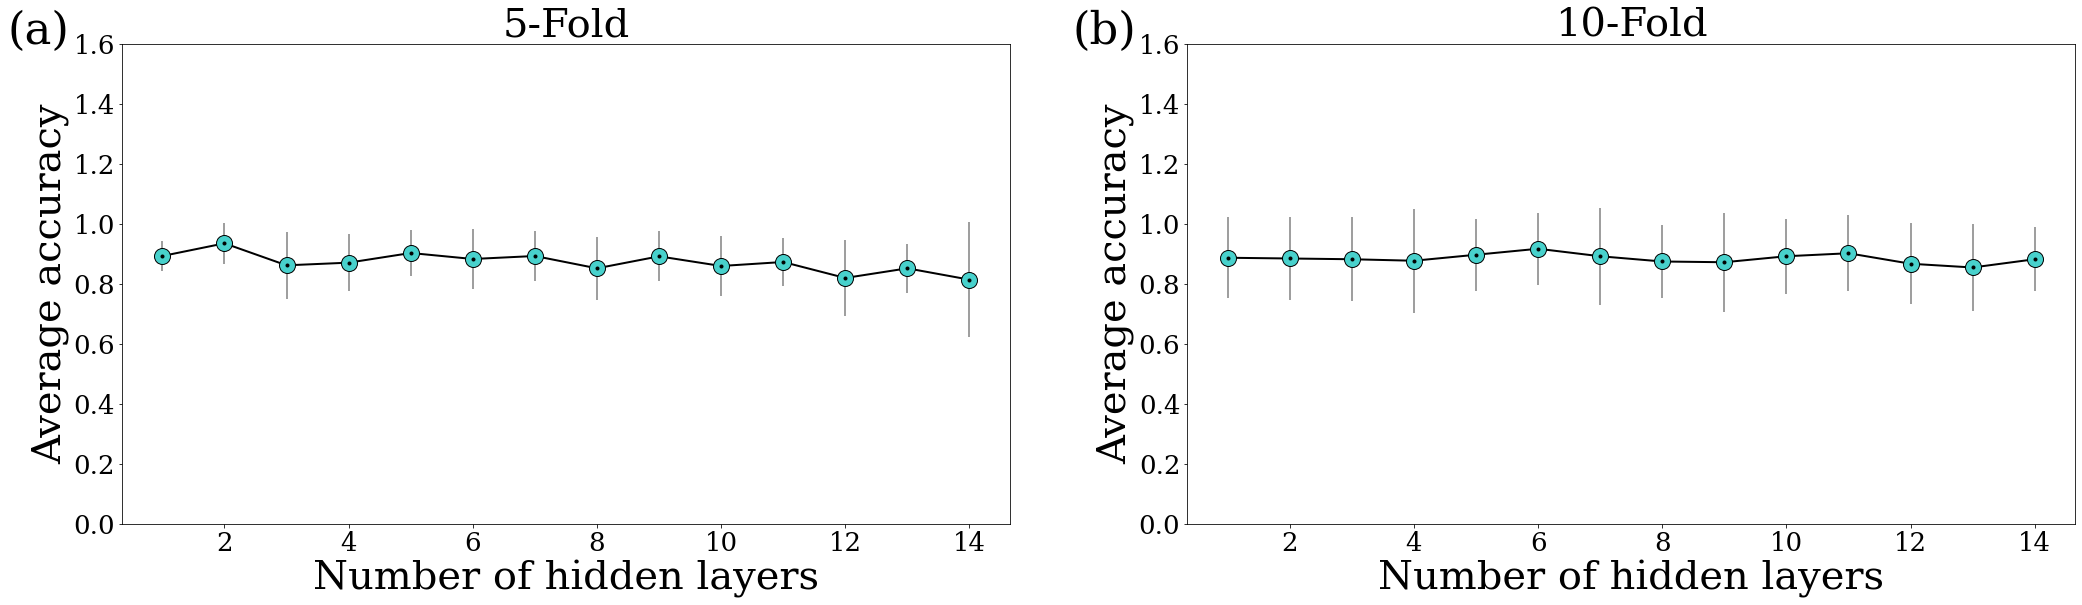

In [ ]:
# Plotting the results

n_hidden = np.arange(1,15,1)
plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(35,30))

# 5-fold
ax1 = plt.subplot(321)
ax1.plot(n_hidden, Acc_avr5fold_list_n_hidden, '-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="mediumturquoise", label = r"")
ax1.set_ylim(0, 1.6)
ax1.set_ylabel(r'Average accuracy', family="serif",fontsize = 40)
ax1.set_xlabel(r'Number of hidden layers', family="serif",fontsize = 40)
ax1.text(-1.5, 1.6,r'(a)', family="serif", fontsize=45)
ax1.set_title(r'5-Fold', fontsize =40, family = 'serif')
ax1.errorbar(n_hidden, Acc_avr5fold_list_n_hidden, yerr=Acc_dev5fold_list_n_hidden, fmt='.k',ecolor='gray')

# 10 - FOLD
ax2 = plt.subplot(322)
ax2.plot(n_hidden, Acc_avr10fold_list_n_hidden, '-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="mediumturquoise", label = r"")
ax2.set_ylim(0, 1.6)
ax2.set_ylabel(r'Average accuracy', family="serif",fontsize = 40)
ax2.errorbar(n_hidden, Acc_avr10fold_list_n_hidden, yerr=Acc_dev10fold_list_n_hidden, fmt='.k',ecolor='gray')
ax2.set_xlabel(r'Number of hidden layers', family="serif",fontsize = 40)
ax2.text(-1.5, 1.6,r'(b)', family="serif", fontsize=45)
ax2.set_title(r'10-Fold', fontsize =40, family = 'serif')

### **Changing the number of epochs**

In [ ]:
# Changing the number of epochs
dropout=0.1
n_hidden = 1
batch_size=10
niter=2
seed = 1

epochs = np.array([1,2,3,4,5,6,7,8,9,10,15,20,30,50,100,150,200])
Acc_avr5fold_list_n_epochs = []
Acc_dev5fold_list_n_epochs = []
Acc_avr10fold_list_n_epochs = []
Acc_dev10fold_list_n_epochs = []
for i in epochs:
  # With xfold = 5
  xfold = 5
  Network5fold, Y_pred5fold, Acc_avr5fold, Acc_dev5fold = \
  train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                            epochs=i, batch_size=batch_size,
                            niter=niter, xfold=xfold, seed=seed, verbose=True)
  Acc_avr5fold_list_n_epochs.append(Acc_avr5fold)
  Acc_dev5fold_list_n_epochs.append(Acc_dev5fold)

  # With xfold = 10
  xfold = 10
  Network10fold, Y_pred10fold, Acc_avr10fold, Acc_dev10fold = \
  train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                            epochs=i, batch_size=batch_size,
                            niter=niter, xfold=xfold, seed=seed, verbose=True)
  Acc_avr10fold_list_n_epochs.append(Acc_avr10fold)
  Acc_dev10fold_list_n_epochs.append(Acc_dev10fold)

Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 1, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 1, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 2, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 2, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 3, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 3, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 4, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 4, batch_size= 10
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 5, batch_size= 10
Training size = 47 

In [ ]:
print(Acc_avr5fold_list_n_epochs)
print(Acc_dev5fold_list_n_epochs)
print(Acc_avr10fold_list_n_epochs)
print(Acc_avr10fold_list_n_epochs)

[0.8477777779102326, 0.8544444501399994, 0.8866666615009308, 0.9177777767181396, 0.8877777755260468, 0.9177777767181396, 0.8766666650772095, 0.8877777755260468, 0.8966666638851166, 0.8855555593967438, 0.9188888907432556, 0.8777777791023255, 0.9055555582046508, 0.8977777779102325, 0.8977777779102325, 0.8877777755260468, 0.8855555593967438]
[0.14932357767143611, 0.10452124653036189, 0.10420777337141965, 0.07555555245455667, 0.1238726958650681, 0.07555555245455667, 0.10720351295327119, 0.11346941998950397, 0.10244540794869537, 0.08549781041470711, 0.1079608978787438, 0.1414213510860285, 0.0997837109433635, 0.10009871656307166, 0.10009871656307166, 0.1238726958650681, 0.08549781041470711]
[0.8950000047683716, 0.8650000050663949, 0.8875000059604645, 0.8525000050663948, 0.8950000047683716, 0.885000005364418, 0.8950000047683716, 0.9075000047683716, 0.8725000053644181, 0.8900000050663948, 0.8325000062584877, 0.8950000047683716, 0.9050000041723252, 0.8550000041723251, 0.8850000038743019, 0.9075

Text(0, 0.5, 'Average accuracy')

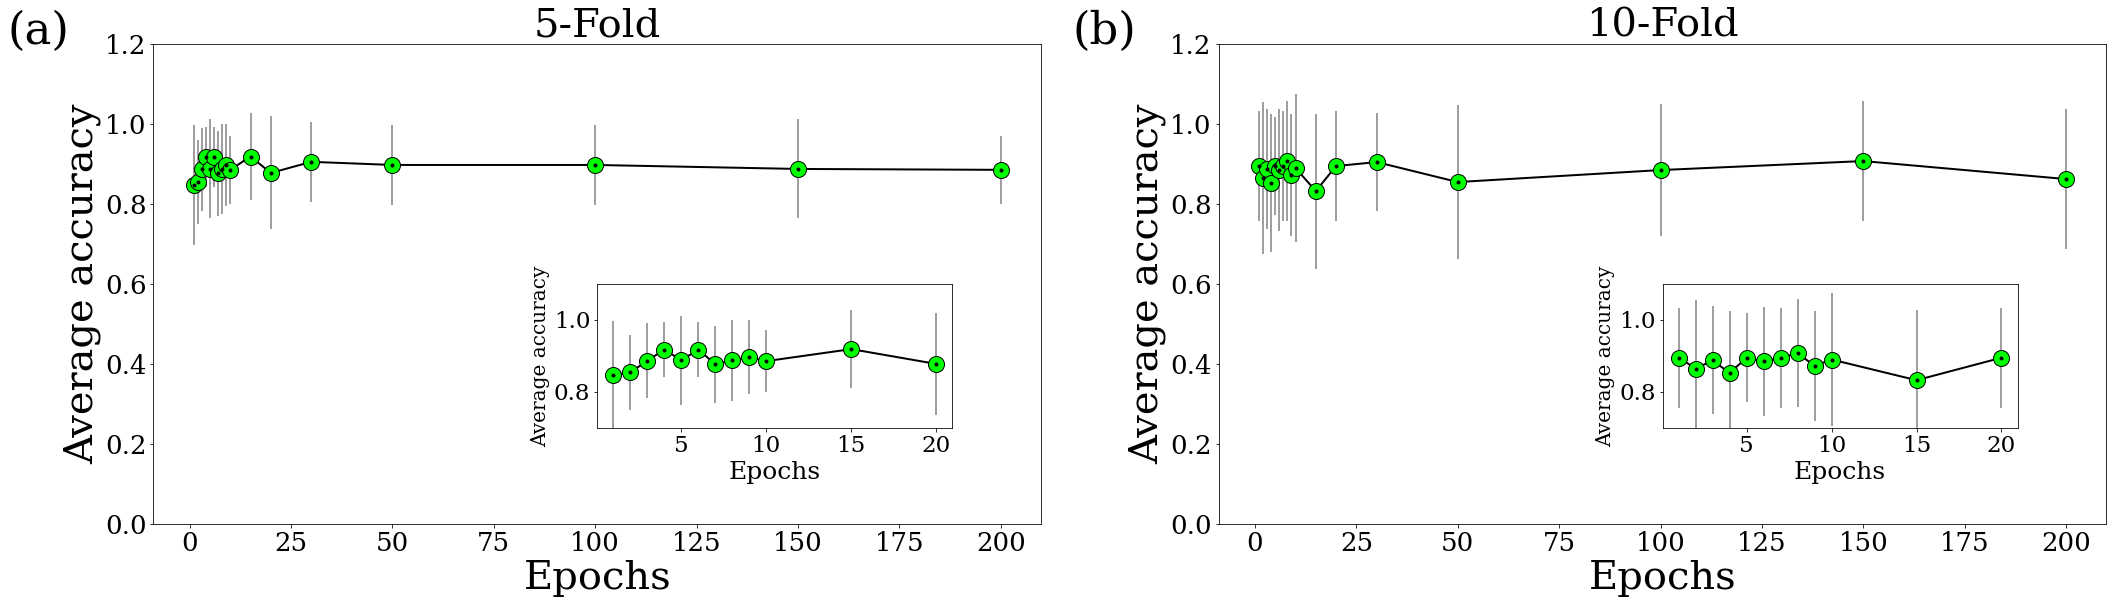

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
# Plotting the results
epochs = np.array([1,2,3,4,5,6,7,8,9,10,15,20,30,50,100,150,200])
epochs2 =np.array([1,2,3,4,5,6,7,8,9,10,15,20,])
Acc2 = Acc_avr5fold_list_n_epochs[:12]

plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels
plt.rcParams["font.family"] = "serif"
fig = plt.figure(figsize=(35,30))

# 5-fold
ax1 = plt.subplot(321)
ax1.plot(epochs, Acc_avr5fold_list_n_epochs, '-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="lime")

#small plot
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
axsmall1 = ax1.inset_axes([0.1,0.1,0.1,0.1])
ip = InsetPosition(ax1, [0.5,0.2,0.4,0.3])  #X, Y, X_size, Y_size
axsmall1.set_axes_locator(ip)
axsmall1.plot(epochs2,Acc2,'-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="lime")
axsmall1.set_ylim(0.7,1.1)
axsmall1.errorbar(epochs2, Acc2, yerr=Acc_dev5fold_list_n_epochs[:12], fmt='.k',ecolor='gray')
axsmall1.set_ylabel(r'Average accuracy', family="serif",fontsize = 20)
axsmall1.set_xlabel(r'Epochs', family="serif",fontsize = 25)
plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels

ax1.set_ylim(0, 1.2)
#ax1.set_xlim(0, 30)
ax1.set_ylabel(r'Average accuracy', family="serif",fontsize = 40)
ax1.set_xlabel(r'Epochs', family="serif",fontsize = 40)
ax1.text(-45, 1.2,r'(a)', family="serif", fontsize=45)
ax1.set_title(r'5-Fold', fontsize =40, family = 'serif')
ax1.errorbar(epochs, Acc_avr5fold_list_n_epochs, yerr=Acc_dev5fold_list_n_epochs, fmt='.k',ecolor='gray')

plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels
# 10 - FOLD
ax2 = plt.subplot(322)
ax2.plot(epochs, Acc_avr10fold_list_n_epochs, '-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="lime")
ax2.set_ylim(0, 1.2)
ax2.set_ylabel(r'Average accuracy', family="serif",fontsize = 40)
ax2.errorbar(epochs, Acc_avr10fold_list_n_epochs, yerr=Acc_dev10fold_list_n_epochs, fmt='.k',ecolor='gray')
ax2.set_xlabel(r'Epochs', family="serif",fontsize = 40)
ax2.text(-45, 1.2,r'(b)', family="serif", fontsize=45)
ax2.set_title(r'10-Fold', fontsize =40, family = 'serif')

Acc3 = Acc_avr10fold_list_n_epochs[:12]
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
axsmall2 = ax2.inset_axes([0.1,0.1,0.1,0.1])
ip = InsetPosition(ax2, [0.5,0.2,0.4,0.3])  #X, Y, X_size, Y_size
axsmall2.set_axes_locator(ip)
axsmall2.plot(epochs2,Acc3,'-',lw=2,color='k', marker='o', markersize=16,markerfacecolor="lime")
axsmall2.set_ylim(0.7,1.1)
axsmall2.errorbar(epochs2, Acc3, yerr=Acc_dev10fold_list_n_epochs[:12], fmt='.k',ecolor='gray')
axsmall2.set_xlabel(r'Epochs', family="serif",fontsize = 25)
axsmall2.set_ylabel(r'Average accuracy', family="serif",fontsize = 20)

## **Plotting the best results**

### **Metabolic Raw Data**

Training size = 47 input_dim = 20 output_dim = 1 hidden_dim = 20 nbr_hidden = 1 epochs = 30, batch_size= 10
Acc = 0.88 (+/- 0.12)


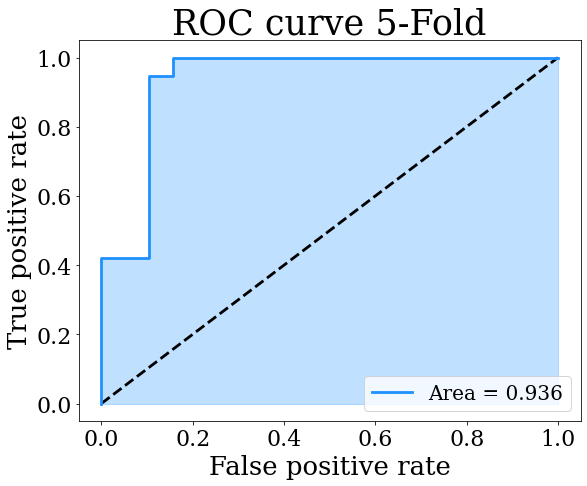

Training size = 47 input_dim = 20 output_dim = 1 hidden_dim = 20 nbr_hidden = 1 epochs = 30, batch_size= 10
Acc = 0.87 (+/- 0.14)


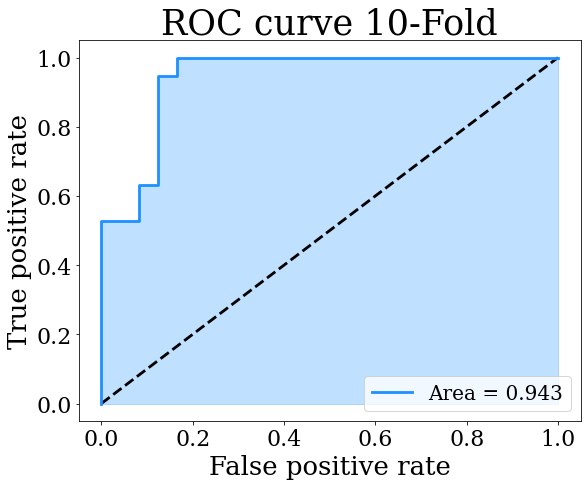

In [ ]:
# Classification parameters (fixed)
n_hidden = 1
dropout = 0.1
epochs = 30
batch_size = 10
niter = 2
seed = 100

# Classification 5 fold
xfold = 5
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=True)

print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size, color = 'dodgerblue')


xfold = 10
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=True)

print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size, color= 'dodgerblue')

In [7]:
# Classification parameters (fixed)
n_hidden = 1
dropout = 0.1
epochs = 30
batch_size = 10
niter = 2
seed = 100

# Classification 5 fold
xfold = 5
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=True)

print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
PR(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size, color = 'mediumaquamarine')


Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 30, batch_size= 10
Acc = 0.89 (+/- 0.08)


ValueError: ignored

### **Data of biomarkers concentrationn corresponding to all the metabolites known that can *E. coli* cell membrane.**

Acc = 0.88 (+/- 0.12)


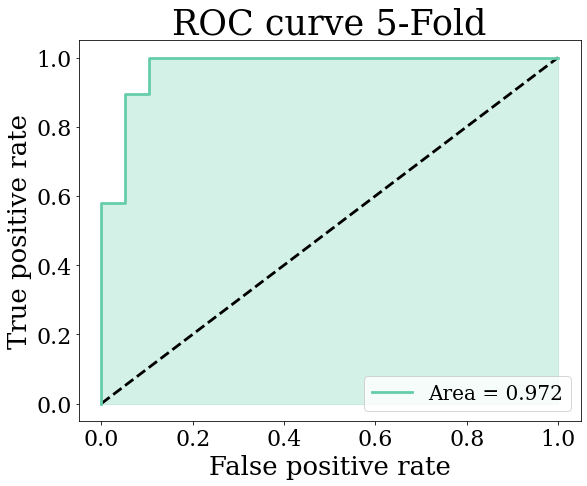

Acc = 0.86 (+/- 0.14)


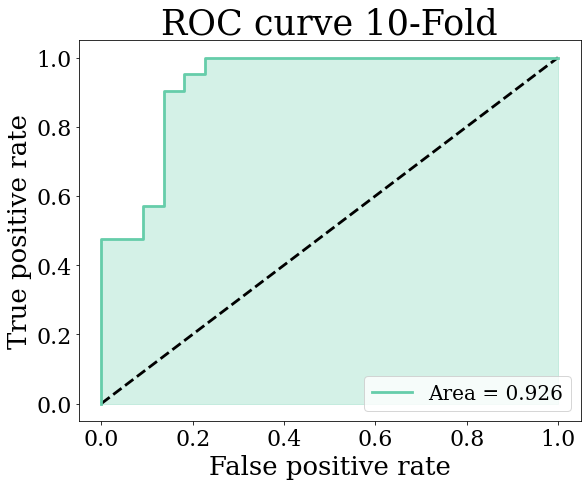

In [ ]:
"""
The classification take as input a set of biomarkers turned on running 
COBRA on a wilde type strain
Then COBRA output (Y_COBRA) to train a post ANN
"""
# Collecting the Data
reservoir_in  = dir+'X_exchange' # Biomarker concentrations
                                 # crossing the membrane
reservoir_out = dir+'Y_COBRA'
list_out  = dir+'Y_sensor_20' # list of biosensors, 
                              # i.e. flux calculared by COBRA
cobrafile = dir+'sbml_model_E_coli_iAF1260.xml' 

# Generate the training set with COBRA, 
# running COBRA on given biomarker concentrations
IN =  read_training_set_cobra(reservoir_in)
list_out = read_out_flux_list(list_out)
strain, OUT = create_output_training_set_cobra(list_out, IN, cobrafile=cobrafile)
write_training_set_cobra(OUT, reservoir_out)
data_X = reservoir_out
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)

# Parameters
n_hidden=1  
dropout=0.1
epochs=30
batch_size=10
niter=2
seed = 100

# 5 FOLD
xfold = 5
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=False)

print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size, color='mediumaquamarine')


# 10 FOLD
xfold = 10
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=False)

print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size, color='mediumaquamarine')

# **2nd Question:** Could an *E. coli* strain be engineered with no more than 4 biosensors such that the biosensors responses enable one to distinguished severe from non severe samples?

## **Selecting the 4 biosensors**

### **10 and 5-fold together** 

Iterator of 5:  1
Iterator of 5:  2
Iterator of 5:  3
Iterator of 5:  4
Iterator of 5:  5
Iterator of 5:  6
Iterator of 5:  7
Iterator of 5:  8
Iterator of 5:  9
Iterator of 5:  10
Iterator of 5:  11
Iterator of 5:  12
Iterator of 5:  13
Iterator of 5:  14
Iterator of 5:  15
Iterator of 5:  16
SENSOR: ['MNXM42@MNXC3', 'MNXM97@MNXC3', 'MNXM4708@MNXC3', 'MNXM58@MNXC3']
Acc = 0.78 (+/- 0.19)


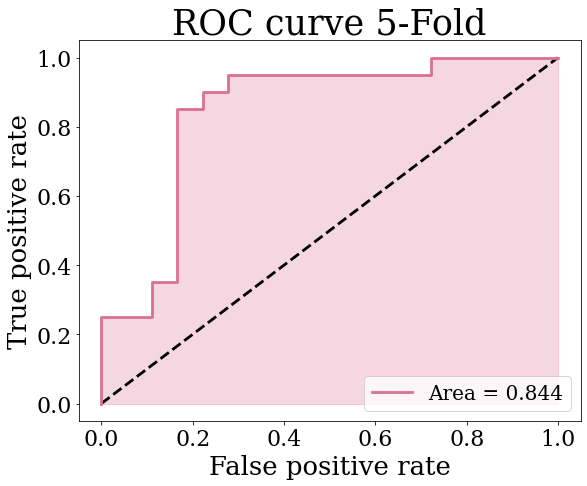

Iterator of 10:  1
Iterator of 10:  2
Iterator of 10:  3
Iterator of 10:  4
Iterator of 10:  5
Iterator of 10:  6
Iterator of 10:  7
Iterator of 10:  8
Iterator of 10:  9
Iterator of 10:  10
Iterator of 10:  11
Iterator of 10:  12
Iterator of 10:  13
Iterator of 10:  14
Iterator of 10:  15
Iterator of 10:  16
SENSOR: ['MNXM61@MNXC3', 'MNXM231@MNXC3', 'MNXM105630@MNXC3', 'MNXM91@MNXC3']
Acc = 0.83 (+/- 0.17)


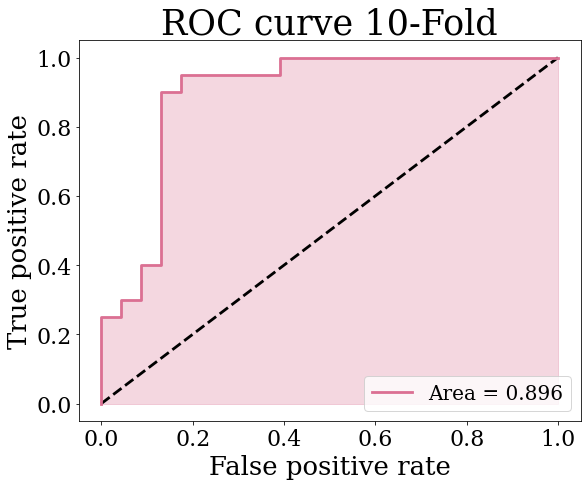

In [ ]:
def SENSORS_deletion(X_best_xfold, SENSOR, reduced_number, threshold, n_hidden, dropout, batch_size, niter, xfold, seed, verbose=False):
  """
    This function reduces the list of the 20 biosensor down to 'reduced_number'. It returns
    the array vector 'X_best_xfold' and the 'SENSOR' when the corresponding metabolites have been removed.
    
    The variable j is created in order to avoid a loop in the it is not to reduced the list.
  """
  j=0
  while (X_best_xfold.shape[1] > reduced_number) and (j <= threshold):
    X_best_xfold_iter, column_best_xfold, Acc_avr_best_xfold, Acc_dev_best_xfold = remove_column_best(X_best_xfold,Y, n_hidden=n_hidden, dropout=dropout, epochs=epochs, batch_size=batch_size,niter=niter, xfold=xfold, seed=seed, verbose=False)
    j = j + 1
    print('Iterator of {}: '.format(xfold), j)
    if (column_best_xfold != -1) and (Acc_avr_best_xfold>=0.8):
      X_best_xfold = X_best_xfold_iter
      del SENSOR[column_best_xfold]
  return X_best_xfold, SENSOR

# Collecting the Data
reservoir_in  = dir+'X_exchange' # Biomarker concentrations
                                 # crossing the membrane
reservoir_out = dir+'Y_COBRA'
list_out  = dir+'Y_sensor_20' # list of biosensors, 
                              # i.e. flux calculated by COBRA
cobrafile = dir+'sbml_model_E_coli_iAF1260.xml' 

# Generate the training set with COBRA, 
# running COBRA on given biomarker concentrations
IN =  read_training_set_cobra(reservoir_in)
list_out = read_out_flux_list(list_out)
strain, OUT = create_output_training_set_cobra(list_out, IN, cobrafile=cobrafile)
write_training_set_cobra(OUT, reservoir_out)
data_X = reservoir_out
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)


# Parameters (fixed)
n_hidden=1  
dropout=0.1
epochs=30
batch_size=10
niter=2
seed = 100
reduced_number=4
threshold = 25   # Can be changed, used to stop a possible loop


# 5-fold validation
SENSOR_5fold = list(list_out.keys())
xfold = 5
X_best_5fold, SENSOR_5fold = SENSORS_deletion(X, SENSOR_5fold, reduced_number, threshold, n_hidden, dropout, batch_size, niter, xfold, seed, verbose=False)
Network_5fold, Y_pred_5fold, Acc_avr_5fold, Acc_dev_5fold = \
train_model_classification(X_best_5fold, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold,
                           seed=seed, verbose=False)
print("SENSOR:",SENSOR_5fold)
print("Acc = %.2f (+/- %.2f)" % (Acc_avr_5fold, Acc_dev_5fold))
ROC(X_best_5fold,Y, Network_5fold, xfold=xfold, epochs=epochs, batch_size=batch_size, color = 'palevioletred')



# 10-fold validation
SENSOR_10fold = list(list_out.keys())
xfold = 10
X_best_10fold, SENSOR_10fold = SENSORS_deletion(X, SENSOR_10fold, reduced_number, threshold, n_hidden, dropout, batch_size, niter, xfold, seed, verbose=False)
Network_10fold, Y_pred_10fold, Acc_avr_10fold, Acc_dev_10fold = \
train_model_classification(X_best_10fold, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold,
                           seed=seed, verbose=False)
print("SENSOR:",SENSOR_10fold)
print("Acc = %.2f (+/- %.2f)" % (Acc_avr_10fold, Acc_dev_10fold))
ROC(X_best_10fold,Y, Network_10fold, xfold=xfold, epochs=epochs, batch_size=batch_size, color = 'palevioletred')